In [2]:
import numpy  as np
import pandas as pd

import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

import plotly.graph_objs as go

from sklearn import cluster

import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

from plotly.offline import download_plotlyjs, plot, init_notebook_mode, iplot
init_notebook_mode(connected=True)# initiate notebook for offline plot






In [3]:
data = pd.read_csv('Data.csv', sep = ';')
data.head()

,show_id,type,title,country,date_added,Description
0,s47,Movie,1 Chance 2 Dance,United States,"July 1, 2017","Dramas, Romantic Movies, Sports Movies After e..."
1,s48,Movie,1 Mile to You,United States,"July 7, 2017","Dramas, Romantic Movies, Sports Movies After e..."
2,s49,Movie,10 Days in Sun City,"South Africa, Nigeria","October 18, 2019","Comedies, International Movies, Romantic Movie..."
3,s50,Movie,10 jours en or,France,"July 1, 2017","Comedies, Dramas, International Movies When a ..."
4,s51,Movie,"10,000 B.C.","United States, South Africa","June 1, 2019",Action & Adventure Fierce mammoth hunter D'Leh...


In [4]:
corpus = data['Description'].tolist()
corpus[0:1000][0:447]

['Dramas, Romantic Movies, Sports Movies After escaping the bus accident that killed his girlfriend, a high school student channels his grief into running, with the help of a new coach.',
 'Dramas, Romantic Movies, Sports Movies After escaping the bus accident that killed his girlfriend, a high school student channels his grief into running, with the help of a new coach.',
 'Comedies, International Movies, Romantic Movies After his girlfriend wins the Miss Nigeria pageant, a young man faces unexpected competition of his own when he joins her on a campaign in South Africa.',
 'Comedies, Dramas, International Movies When a carefree bachelor is unexpectedly left in charge of a young boy, the two embark on a road trip that will change both of their lives.',
 "Action & Adventure Fierce mammoth hunter D'Leh sets out on an impossible journey to rescue the woman he loves from a vicious warlord and save the people of his village.",
 'International TV Shows, Romantic TV Shows, TV Dramas Upon los

In [5]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [6]:


def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    other_words = [line.rstrip('\n') for line in open('word.txt')] # Load .txt file line by line
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)

        listOfTokens = removeWords(listOfTokens, other_words)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, other_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [7]:
language = 'english'
corpus = processCorpus(corpus, language)
corpus[0:1000][0:460]


['drama romant movi sport movi escap bus accid kill girlfriend high school student channel grief run coach',
 'drama romant movi sport movi escap bus accid kill girlfriend high school student channel grief run coach',
 'comedi intern movi romant movi girlfriend win miss nigeria pageant young man face unexpect competit join campaign south africa',
 'comedi drama intern movi carefre bachelor unexpect left charg young boy embark road trip chang live',
 "action adventur fierc mammoth hunter d'leh set imposs journey rescu woman love vicious warlord save peopl villag",
 'intern show romant show drama lose memori crown princ encount commoneraEUR(tm) life experi unforgett love husband joseonaEUR(tm) oldest bachelorett',
 'documentari intern movi spanish photograph josa(c) daaz spend day live remot mountain connect natur document beauti surround',
 'docuseri scienc natur hundr hardi soul divers background particip play experi explor age sex happi aspect human',
 'drama intern movi sport movi ma

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

1024 rows


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
channel,0.332186,0.332186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
grief,0.332186,0.332186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
coach,0.311611,0.311611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bus,0.303788,0.303788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accid,0.276437,0.276437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
final_df.T.nlargest(5, 0)


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
channel,0.332186,0.332186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
grief,0.332186,0.332186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
coach,0.311611,0.311611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bus,0.303788,0.303788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accid,0.276437,0.276437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [35]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [36]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
#silhouette(kmeans_results, final_df, plot=True)

C:\Users\asus\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

C:\Users\asus\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

C:\Users\asus\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

C:\Users\asus\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

C:\Users\asus\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

C:\Users\asus\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

C:\Users\asus\miniconda3\lib\site-

In [37]:
   def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

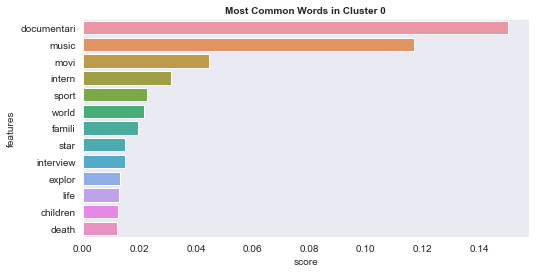

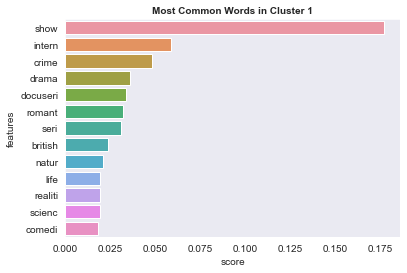

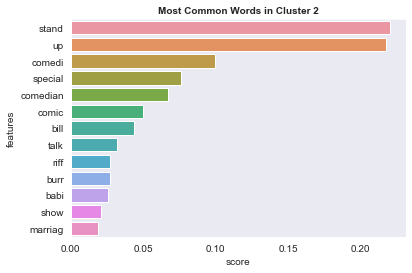

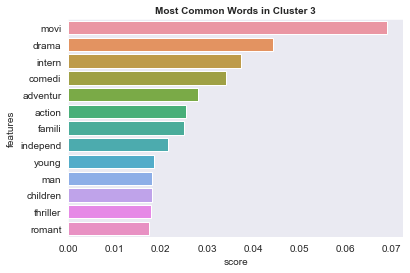

In [38]:
best_result = 4
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [39]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

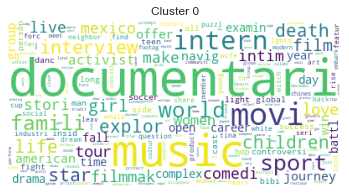

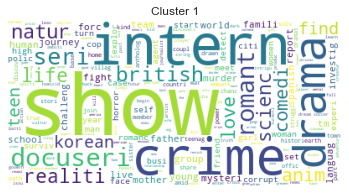

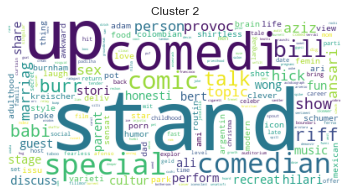

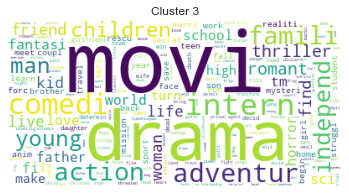

In [40]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [27]:
labels = kmeans.labels_ 
data['label'] = labels
data.head()

,show_id,type,title,country,date_added,Description,label
0,s47,Movie,1 Chance 2 Dance,United States,"July 1, 2017","Dramas, Romantic Movies, Sports Movies After e...",4
1,s48,Movie,1 Mile to You,United States,"July 7, 2017","Dramas, Romantic Movies, Sports Movies After e...",4
2,s49,Movie,10 Days in Sun City,"South Africa, Nigeria","October 18, 2019","Comedies, International Movies, Romantic Movie...",4
3,s50,Movie,10 jours en or,France,"July 1, 2017","Comedies, Dramas, International Movies When a ...",4
4,s51,Movie,"10,000 B.C.","United States, South Africa","June 1, 2019",Action & Adventure Fierce mammoth hunter D'Leh...,3


In [28]:
movies_count = data[data.type == "Movie"]
tvshows_count = data[data["type"] == "TV Show"]

colors = ["#809fff", "#66ff66"]
trace = go.Pie(labels=["Movies", "Tv Show"], 
               values=[movies_count.type.count(), tvshows_count.type.count()],
               hoverinfo="label+percent", textinfo="label+percent", marker=dict(colors=colors,
                line=dict(color="#2d2d2d", width=2)))

fig = go.Figure(data=[trace])
iplot(fig)


In [29]:
netflix_df_counts = data.country.value_counts()
netflix_df_counts

United States                           331
India                                   135
United Kingdom                           43
Japan                                    35
Canada                                   29
                                       ... 
Ghana                                     1
France, Canada, Belgium                   1
Spain, Italy                              1
United Kingdom, Spain, United States      1
Netherlands, Denmark, South Africa        1
Name: country, Length: 161, dtype: int64

In [30]:
trace = go.Bar(x=netflix_df_counts.index[:15], y=netflix_df_counts, marker=dict(
                  opacity=0.8,
                  color=np.arange(15)
              ))
fig = go.Figure(data=[trace])

fig.update_layout(title="Top 15 Countries by Content")
fig.update_xaxes(title="Country")
fig.update_yaxes(title="Count")

iplot(fig)

In [32]:
year_wise_content = data.date_added.value_counts().index[:20]
year_wise_content

Index(['December 31, 2019', 'October 1, 2017', 'April 1, 2018',
       'November 1, 2019', 'March 1, 2018', 'November 1, 2018',
       'January 1, 2020', 'July 1, 2020', 'July 1, 2017', 'July 12, 2019',
       'November 20, 2019', 'December 1, 2018', 'August 1, 2017',
       'September 1, 2020', 'December 1, 2020', 'August 7, 2017',
       'October 1, 2019', 'December 1, 2019', 'February 15, 2019',
       'January 1, 2019'],
      dtype='object')

<AxesSubplot:xlabel='count', ylabel='date_added'>

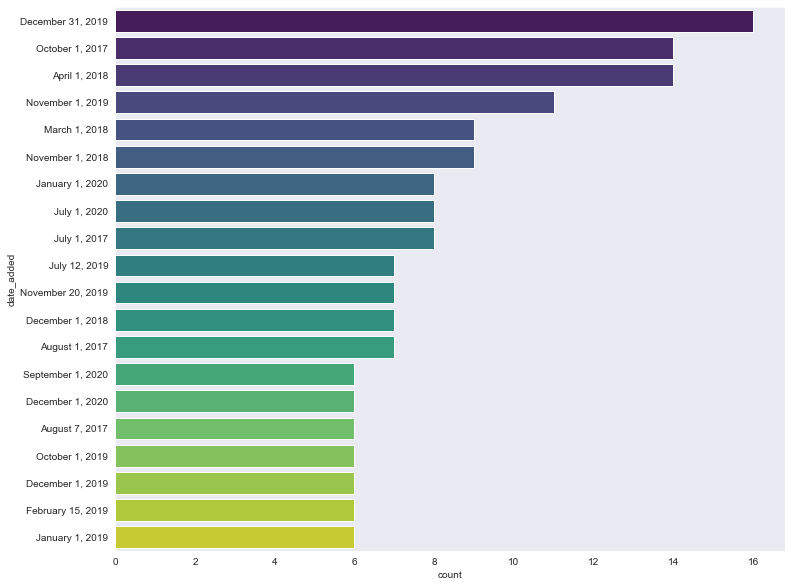

In [33]:
plt.figure(figsize=(12,10))
sns.set_style("dark")
sns.countplot(data=data, y="date_added", order=year_wise_content, palette="viridis")